In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, LinearConstraint
from IPython.core.interactiveshell import InteractiveShell
from common.calculate_variance import calculate_variance

import datetime as dt

InteractiveShell.ast_node_interactivity = "all"

In [46]:
# data 기초 전처리
data = pd.read_csv('../data/AAPL.csv')
data = data.set_index('Date')

# 인덱스를 datetime으로 변경
data.index = pd.to_datetime(data.index)

# test 셋과 train 셋으로 나누기
split_date= dt.datetime(2011,12,5)
train_data = data[data.index<split_date]
test_data = data[data.index>=split_date]

# log 수익률 column 추가
train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
train_data_return = train_data['log_price_return'].dropna()

test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)
test_data_return = test_data['log_price_return'].dropna()


/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_60943/1000520923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_60943/1000520923.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)


In [47]:
train_data['log_price_return']

Date
2000-01-03         NaN
2000-01-04   -0.088077
2000-01-05    0.014527
2000-01-06   -0.090514
2000-01-07    0.046281
                ...   
2011-11-28    0.033936
2011-11-29   -0.007794
2011-11-30    0.023830
2011-12-01    0.014881
2011-12-02    0.004553
Name: log_price_return, Length: 3000, dtype: float64

In [48]:
# dataset 만들기
# train
train_data_set = pd.DataFrame()
var = calculate_variance(train_data_return)
train_data_set['rv'] = np.sqrt(var)
train_data_set['log_return'] = train_data_return
# test
test_data_set = pd.DataFrame()
var = calculate_variance(test_data_return)
test_data_set['rv'] = np.sqrt(var)
test_data_set['log_return'] = test_data_return


In [49]:
test_data_set

,rv,log_return
Date,,
2011-12-12,0.005368,-0.004532
2011-12-13,0.005945,-0.007763
2011-12-14,0.011460,-0.022420
2011-12-15,0.011413,-0.003293
2011-12-16,0.011174,0.005474
...,...,...
2013-11-22,0.008674,-0.002575
2013-11-25,0.007545,0.007551
2013-11-26,0.011095,0.018277


In [50]:
# scaling 
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

train_data_minmax = scaler_minmax.fit_transform(train_data_set)
test_data_minmax = scaler_minmax.transform(test_data_set)

# 정규화가 완료된 데이터를 데이터 프레임으로 다시 변경
train_data_df = pd.DataFrame(train_data_minmax, index=train_data_set.index,columns=train_data_set.columns)
test_data_df = pd.DataFrame(test_data_minmax, index=test_data_set.index,columns=test_data_set.columns)

In [51]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

SVR_parameters = [{"C" : [0.1, 1, 10, 100, 1000], "gamma" : [0.0000001,0.000001,0.0001,0.01,1,100,10000,1000000], "nu": [0.1,0.2,0.3,0.4,0.5]}]


tscv = TimeSeriesSplit(n_splits=5)

#모델 생성
svr_rbf = NuSVR(kernel='rbf',max_iter=10000)

#RMSE 평가 지표 함수 
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred,squared=False)), greater_is_better=False)

grid_search = GridSearchCV(estimator=svr_rbf, param_grid=SVR_parameters,scoring=rmse_scorer, cv=tscv)

In [52]:
y_rbf = grid_search.fit(train_data_df[:-1].values,train_data_set[1:]['rv'].values.reshape(-1,))
predicted_y = y_rbf.predict(test_data_df[:-1].values)

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScale

Text(0.5, 0, 'Time(day)')

Text(0, 0.5, 'Squared Volatility')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


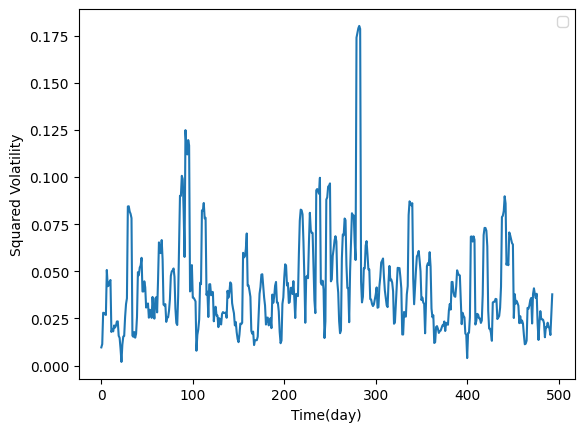

In [84]:
plt.plot(test_data_df[:-1]['rv'].values)
plt.xlabel("Time(day)")
plt.ylabel('Squared Volatility')
plt.legend()
plt.savefig('주가 변동성.png', bbox_inches='tight')

MinMaxScaler()

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<Figure size 1500x1000 with 0 Axes>

Text(0.5, 0, 'Time(day)')

Text(0, 0.5, 'Squared Volatility (normalized data)')

(0.0, 0.045)

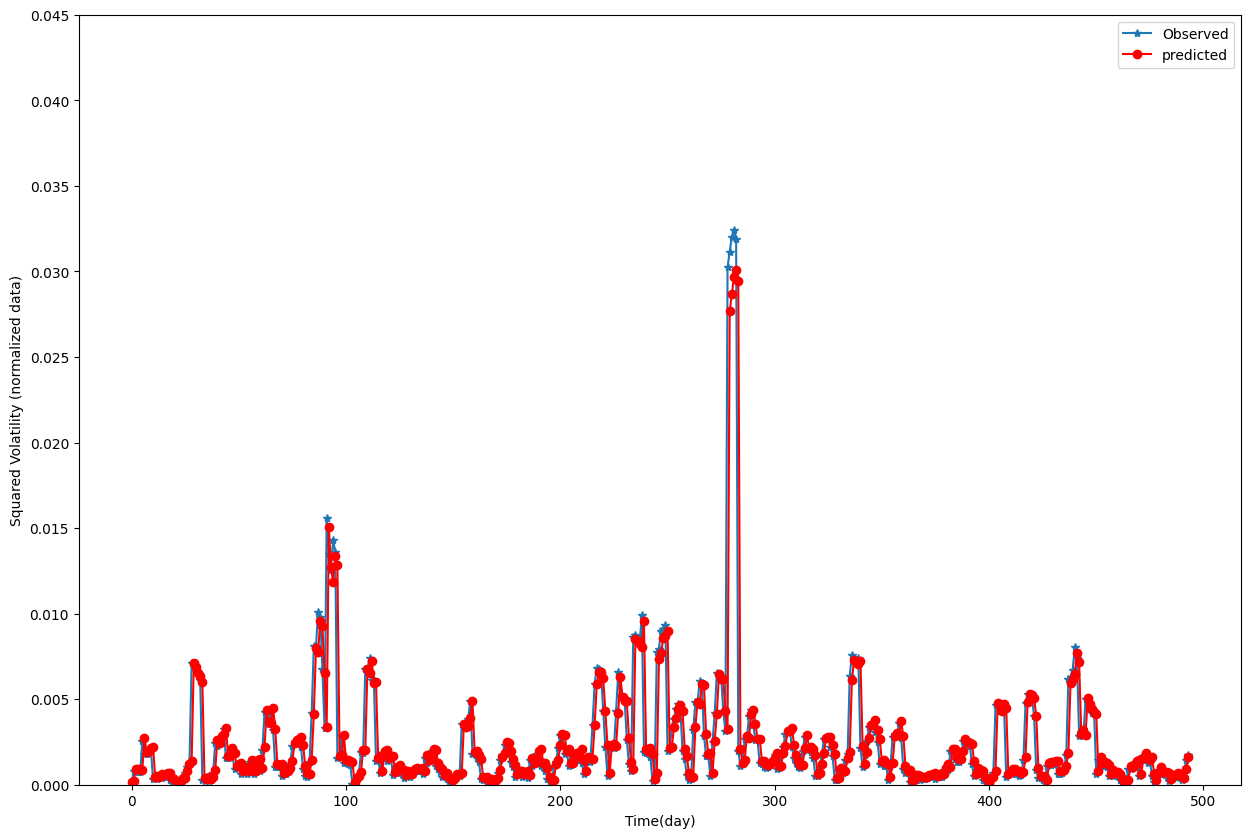

In [78]:
# test realized volatiliy 값을 train realized min-max scaler로 scaling 

rv_train = pd.DataFrame(train_data_set['rv'])
scaler_result = MinMaxScaler()
scaler_result.fit(rv_train)
df_y = scaler_result.transform(predicted_y.reshape(-1,1))

plt.figure(figsize=(15,10))
plt.xlabel("Time(day)")
plt.ylabel('Squared Volatility (normalized data)')
plt.ylim([0,0.045])
plt.plot(test_data_df[1:].rv.values**2,marker='*', label = "Observed")
plt.plot(df_y**2,marker='o', label='predicted', color='red')

plt.legend()
plt.savefig('SVR.png', bbox_inches='tight')


In [58]:
mean_squared_error(df_y,test_data_df[1:].rv.values,squared=False)

0.015044650925184767

MinMaxScaler()

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Normal')

Text(0.5, 0, 'Nu-SVR')

Text(0, 0.5, 'Squared Volatility (normalized data)')

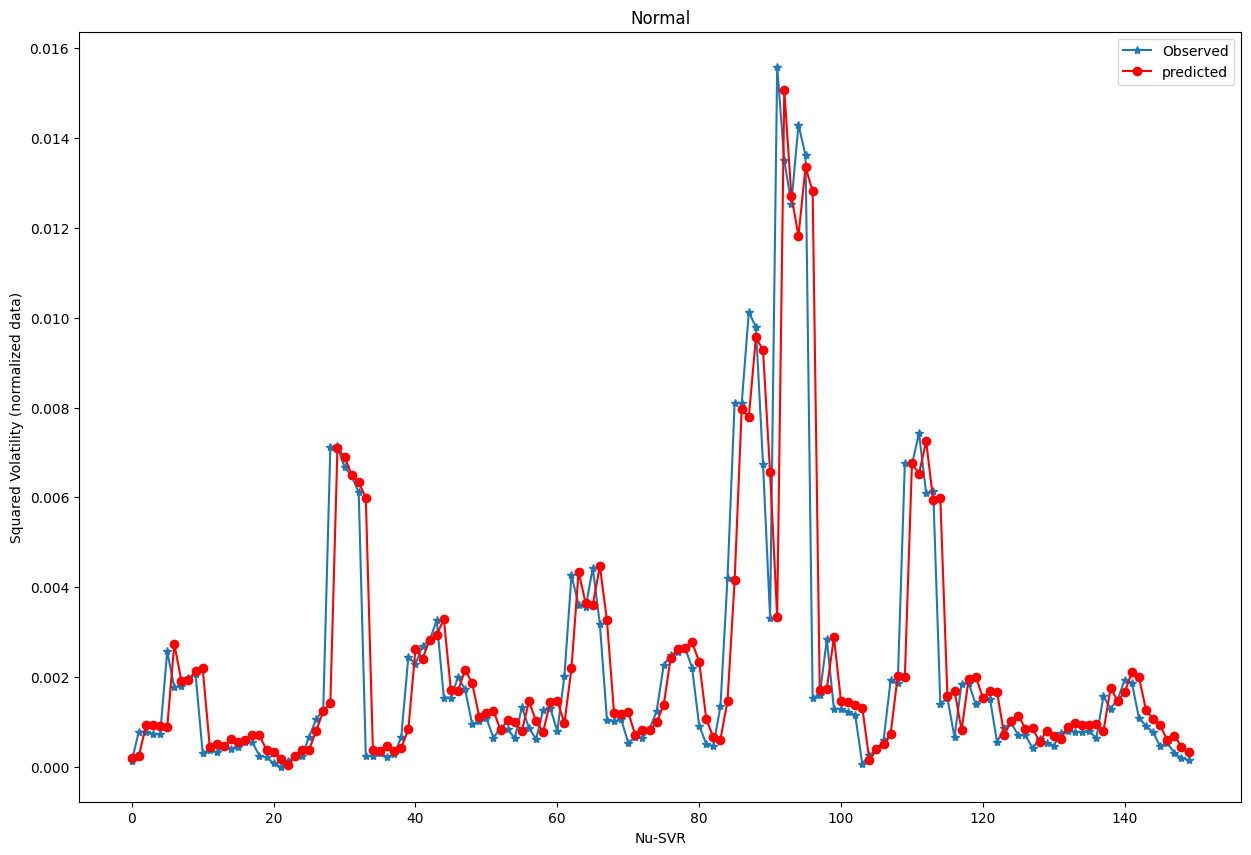

In [90]:
rv_train = pd.DataFrame(train_data_set['rv'])
scaler_result = MinMaxScaler()
scaler_result.fit(rv_train)

df_y = scaler_result.transform(predicted_y.reshape(-1,1))

plt.figure(figsize=(15,10))
plt.plot(test_data_df[1:151].rv.values**2,marker='*', label = "Observed")
plt.plot(df_y[:150]**2,marker='o', label='predicted', color='red')
plt.title("Normal")

plt.xlabel("Nu-SVR")
plt.ylabel('Squared Volatility (normalized data)')

plt.legend()

plt.savefig('확대LSTM.png', bbox_inches='tight')

In [56]:
grid_search.best_params_

{'C': 100, 'gamma': 0.01, 'nu': 0.5}

In [70]:
def calculate_RMSLE(y_hat, y):
    n = len(y_hat)-1
    df = y_hat[1:].values - y[:-1].values
    result = (1/n) * (df**2).sum()
    return np.sqrt(result)

In [71]:
calculate_RMSLE(pd.DataFrame(df_y),pd.DataFrame(test_data_df[1:].rv.values))

0.002484328345834251